In [1]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = "./"
"chmod 600 ./kaggle.json"

'chmod 600 ./kaggle.json'

In [2]:
!kaggle competitions download -c nlp-getting-started

  0%|                                                | 0.00/593k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 3.59MB/s]


In [3]:
%%capture
!unzip "./nlp-getting-started.zip"

In [3]:
!pip install keras

# Introduction

For this project, we will be tackling a text classification problem using an RNN. The data we will be using from Kaggle contains a keyword, location, and text from tweets that we must determine are for a real disaster or not. 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks
from kerastuner import RandomSearch, HyperParameters
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# for word processing
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import binarize

2023-08-03 19:00:59.162826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 19:01:03.519134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_5193/165142046.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperParameters
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt i

# EDA

In this section we will load in the data and use some visualizations to explore it and then clean the data to prepare it for modeling.

In [2]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [21]:
#During eda, there were determined to be a lot of non-valid characters in keyword and location, this is to clean that for better visualizaitons (more comprehensive pre-processing will be done later)
df_train['keyword'] = df_train['keyword'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df_train['location'] = df_train['location'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

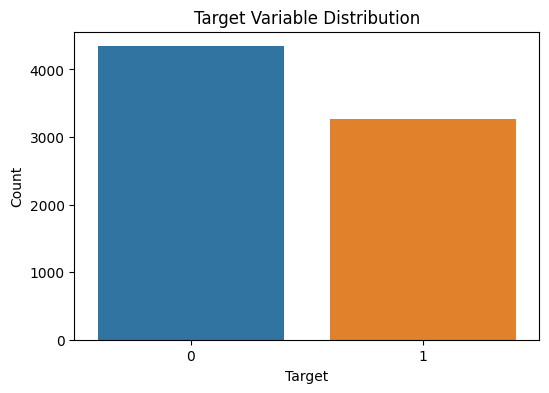

In [22]:
# Countplot of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Target Variable Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

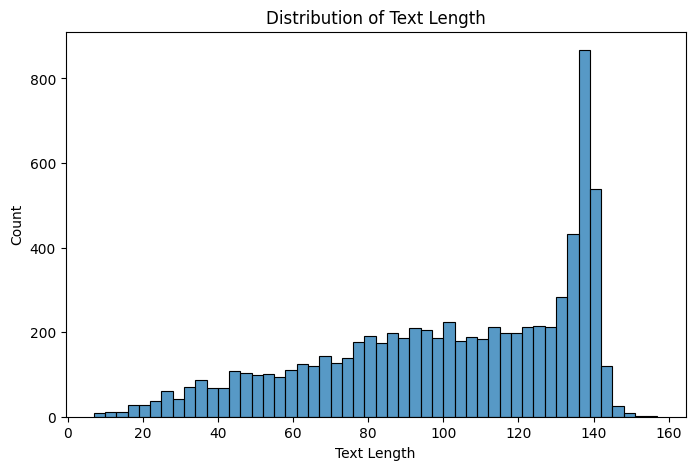

In [23]:
# Histogram of text lengths
df_train['text_length'] = df_train['text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df_train['text_length'], bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

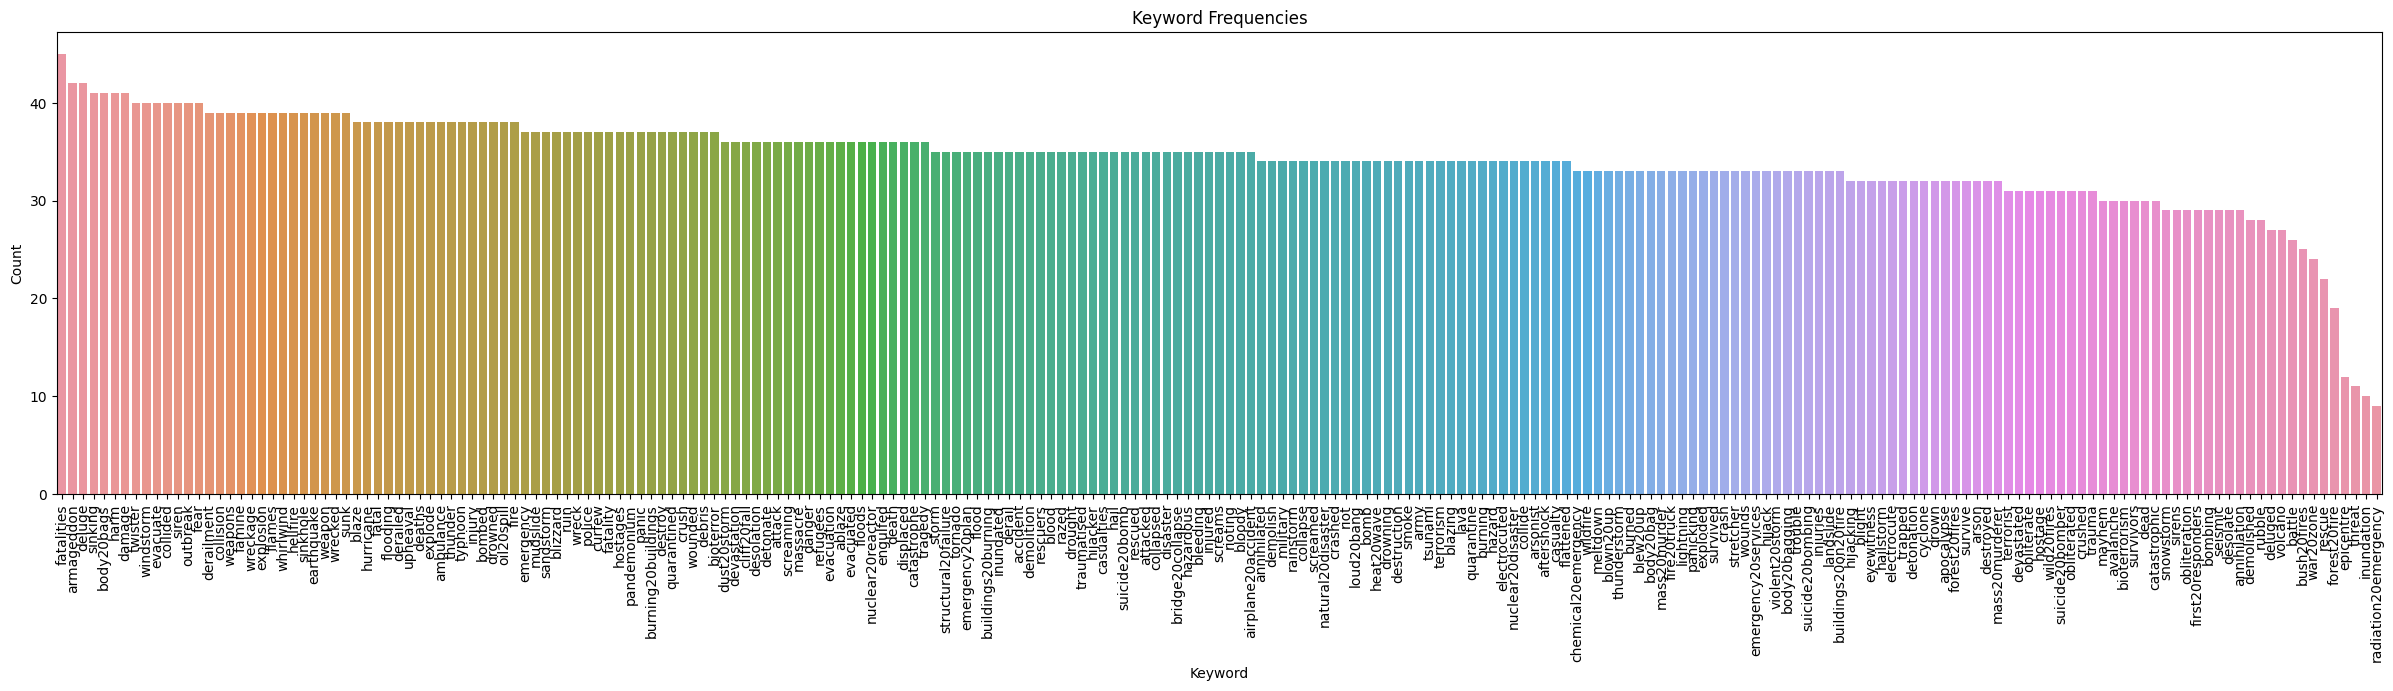

In [27]:
# Bar Plot of Keyword Frequencies
plt.figure(figsize=(30, 6))
sns.countplot(x='keyword', data=df_train, order=df_train['keyword'].value_counts().index)
plt.title('Keyword Frequencies')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

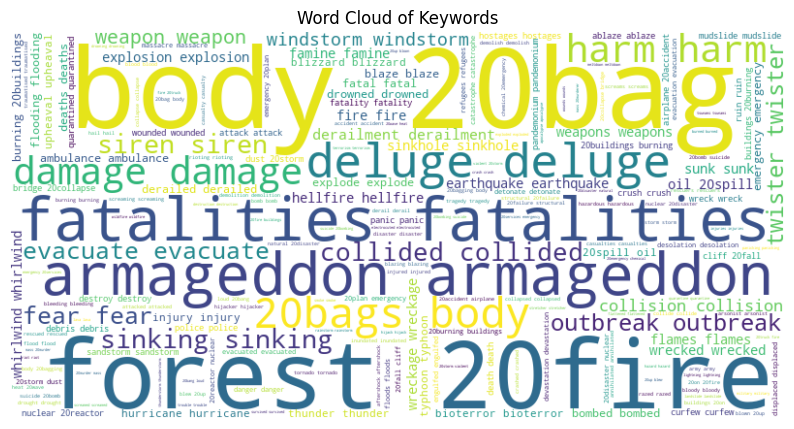

In [15]:
# Combine all keywords into a single string
all_keywords = ' '.join(df_train['keyword'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')
plt.show()

Text(0.5, 1.0, 'Word Cloud for Non-Disaster Tweets')

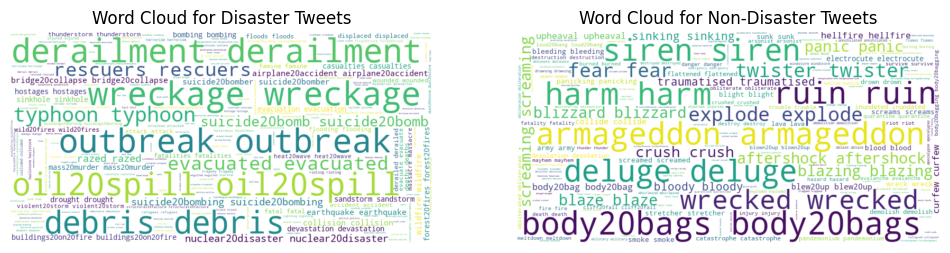

In [32]:
disaster_keywords = ' '.join(df_train[df_train['target'] == 1]['keyword'].dropna())
non_disaster_keywords = ' '.join(df_train[df_train['target'] == 0]['keyword'].dropna())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_keywords)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')

plt.subplot(1, 2, 2)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_keywords)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Disaster Tweets')

In [4]:
# Data cleaning
def clean_text(text):
    # Check if text is not NaN
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        # Remove special characters and digits
        text = re.sub(r"[^\w\s]", "", text)
        text = re.sub(r"\d+", "", text)
        # Convert to lowercase
        text = text.lower()
    return text

def remove_stopwords_and_lemmatize(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words("english")]
    # Join the words back to form a sentence
    return " ".join(words)

In [5]:
# Preprocess the text data
df_train["text"] = df_train["text"].apply(clean_text)
df_train["text"] = df_train["text"].apply(remove_stopwords_and_lemmatize)

df_test["text"] = df_test["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(remove_stopwords_and_lemmatize)

# Feature extraction on training data
train_corpus = df_train["text"].tolist()
vector = TfidfVectorizer(max_features=1500)
interemresponse = vector.fit(train_corpus)

train_and_val = interemresponse.transform(df_train["text"]).todense()

X_train, X_val, y_train, y_val = train_test_split(train_and_val, df_train["target"], test_size=0.08, random_state=42)

X_test = interemresponse.transform(df_test["text"]).todense()

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)

(7003, 1500) (610, 1500) (3263, 1500)
(7003,) (610,)


Preparing the data for use by tensorflow

In [6]:
from random import sample
import math
val_size = 0.08
num_train = math.floor((1 - val_size) * df_train.shape[0])
train_rows = sample([i for i in range(df_train.shape[0])], num_train)
val_rows = [i for i in range(df_train.shape[0]) if not i in train_rows]

training_df = df_train.iloc[train_rows]
validation_df = df_train.iloc[val_rows]

features = "text"
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df[features].values, tf.string),
            tf.cast(training_df['target'].values, tf.int32)
        )
    )
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(validation_df[features].values, tf.string),
            tf.cast(validation_df['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_test["text"].values, tf.string)
        )
    )
)

2023-08-03 19:05:14.012763: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 10
    
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Model Architecture:

I folled the outline of the tutorial provided by tensor flow for text classification with RNNs.

In [10]:
num_words = 1500
encoder = tf.keras.layers.TextVectorization(
max_tokens = num_words)
encoder.adapt(training_dataset.map(lambda text, label: text)
)

def build_model(lstm_units, eta):
    model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    input_dim = len(encoder.get_vocabulary()),
    output_dim = 128,
    mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = eta,
      decay_steps = 1000,
      decay_rate=0.9
    ) 
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )    
    return(model)

def gridSearch(lstm_sizes, eta_rates, training_dataset):

    callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

    current_best = (0, None, None)
    for lstm_size in lstm_sizes:
        for eta in eta_rates:
            print("Now fitting model with lstm size =", lstm_size)
            print("Now fitting model with eta =", eta)
            this_model = build_model(lstm_size, eta)
            this_history = this_model.fit(training_dataset,
                                validation_data = validation_dataset,
                                epochs = 50,
                                callbacks = callbacks_list,
                                verbose = 0
                            )
            print("Got last validation accuracy of:", this_history.history["val_accuracy"][-1])
            if this_history.history["val_accuracy"][-1] > current_best[0]:
                current_best = (this_history.history["val_accuracy"][-1], this_history, eta)
        
    return(current_best[1:])

# Results and Analysis

I chose to tune the hyperparamters lstm size and eta rate through a simple grid search function and take the model with the best validation accuracy. As seen below the model had validation accuracy of around .8 and the loss has plateaued. Overall it received a score of .78577 on Kaggle which is okay but not great. This likely means there are improvements to be made in my process from pre-processing, to model architecture, to hyperparameter tuning.

In [11]:
lstm_sizes = [32, 64, 128, 256]
eta_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
(best_history, best_eta) = gridSearch(lstm_sizes, eta_rates, training_dataset)

Now fitting model with lstm size = 32
Now fitting model with eta = 1e-05
Got last validation accuracy of: 0.7852458953857422
Now fitting model with lstm size = 32
Now fitting model with eta = 5e-05
Got last validation accuracy of: 0.800000011920929
Now fitting model with lstm size = 32
Now fitting model with eta = 0.0001
Got last validation accuracy of: 0.7918033003807068
Now fitting model with lstm size = 32
Now fitting model with eta = 0.0005
Got last validation accuracy of: 0.7786885499954224
Now fitting model with lstm size = 32
Now fitting model with eta = 0.001
Got last validation accuracy of: 0.757377028465271
Now fitting model with lstm size = 64
Now fitting model with eta = 1e-05
Got last validation accuracy of: 0.7754098176956177
Now fitting model with lstm size = 64
Now fitting model with eta = 5e-05
Got last validation accuracy of: 0.7934426069259644
Now fitting model with lstm size = 64
Now fitting model with eta = 0.0001
Got last validation accuracy of: 0.7819672226905823

In [12]:
best_history.model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_15 (Embedding)    (None, None, 128)         192000    
                                                                 
 bidirectional_15 (Bidirect  (None, 512)               788480    
 ional)                                                          
                                                                 
 dense_45 (Dense)            (None, 64)                32832     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 16)              

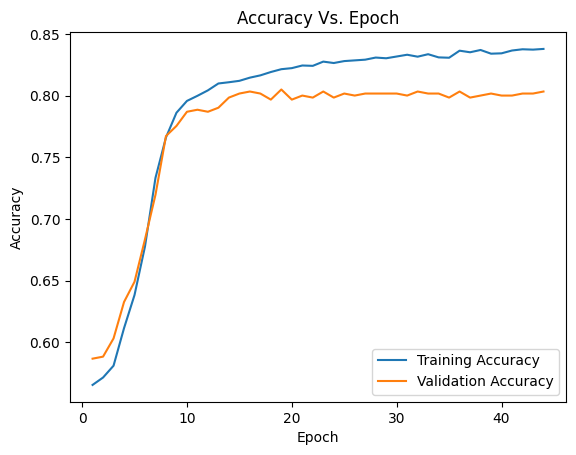

In [19]:
epochs = [i + 1 for i in range(44)]

line1, = plt.plot(epochs, best_history.history["accuracy"], zorder = 0, label = "Training Accuracy")
line2, = plt.plot(epochs, best_history.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch")
plt.show()

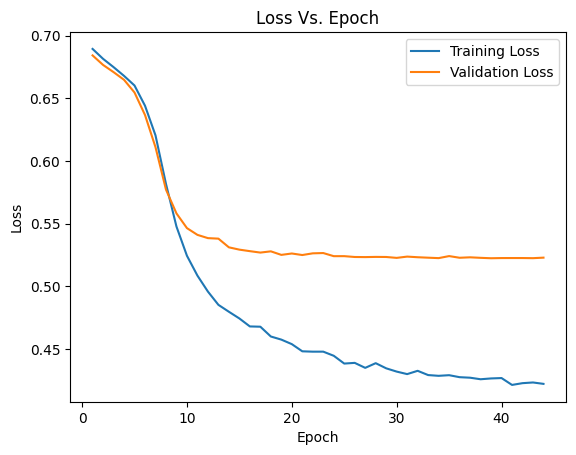

In [20]:
line1, = plt.plot(epochs, best_history.history["loss"], zorder = 0, label = "Training Loss")
line2, = plt.plot(epochs, best_history.history["val_loss"], zorder = 1, label = "Validation Loss")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch")
plt.show()

In [17]:
#Make test set predictions

pred = best_history.model.predict(test_dataset)
pred = pred.reshape(pred.shape[0], )
pred = pred.tolist()
predictions = [round(pred[i]) for i in range(len(pred))]
df_test["target"] = predictions

df_submission = df_test[["id", "target"]]

df_submission.head()
df_submission.to_csv("./Prediction.csv", index = False)

327/327 [==============================] - 3s 8ms/step


![Submission](kaggle_submission.png)

# Conclusion

Through this process I built an RNN that was able to correctly classify a tweet about 80% of the time. In the future, to improve this result I would like to try several things. First, instead of TF-IDF for vectorization I would like to use something pre-trained like Glove. Next, with more time I would like to experiment with more model architectures to see if I could find a more optimal solution. Finally, I would like to build a more robust griid search function that is capable of searching through more hyperparameters to better tune the model I end up using.

# References:

EDA

1. SNS (histplot) - https://seaborn.pydata.org/generated/seaborn.histplot.html

2. SNS (countplot) - https://seaborn.pydata.org/generated/seaborn.countplot.html

3. Wordcloud - https://www.datacamp.com/tutorial/wordcloud-python

Modeling

1. Text classification with an RNN - https://www.tensorflow.org/text/tutorials/text_classification_rnn

2. RNN model building - https://www.tensorflow.org/text/tutorials/text_classification_rnn

3. Prepping data for tensor flow - https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168